# Table of Content (Code Part 3 of 6)

1. [Libraries](#libraries)
2. [Processed Data Exploration](#processed-data-exploration)
3. [Model Selection](#model-selection)

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

In [2]:
allposts = pd.read_csv('../Data/allposts.csv')

# Processed Data Exploration

In [3]:
# Since we have 5000 posts from bouldering and climbharder, we have evenly distributed target.
allposts.subreddit.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

This will act as our baseline model where when predict the subreddit, we will have 50% accuracy.

In [4]:
# Display columns generated
allposts.columns

Index(['Unnamed: 0', 'title', 'selftext', 'splittitle', 'splitstring',
       'titlewordcount', 'wordcount', 'subreddit', 'combinedtext',
       'tokenized_combinedtext', 'lemmatized_tokenized_combinedtext',
       'stemmatized_tokenized_combinedtext'],
      dtype='object')

In this section below, we will explore more on the tokens, stemmatized and lemmatized tokens and to see how different the data will be.

In [5]:
# Define X and y
X = allposts['tokenized_combinedtext']
y = allposts['subreddit']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, 
                                                    random_state=12)

# Fit and transform X with countvectorizer
cvec = CountVectorizer(ngram_range=(1,2), max_df=.95, max_features=1000)
cvec.fit(X_train)
X_train = cvec.transform(X_train)

X_train_df = pd.DataFrame(X_train.todense(),
                          columns=cvec.get_feature_names())

C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
# Show top 10 tokens
X_train_df.sum().sort_values(ascending=False).head(10)


to     25744
the    25561
and    21505
my     13368
of     12918
for    10723
it     10649
in     10489
on     10120
is      8788
dtype: int64

We can see that there are a lot of tokens that are not useful in classifying the output such as to, the, and, of and etc. We have to include stop words in preprocessing.

In [7]:
# Define X and y
X = allposts['tokenized_combinedtext']
y = allposts['subreddit']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, 
                                                    random_state=12)

# Fit and transform X with countvectorizer
cvec = CountVectorizer(ngram_range=(1,2), max_df=.95, max_features=1000, stop_words='english')
cvec.fit(X_train)
X_train = cvec.transform(X_train)

X_train_df = pd.DataFrame(X_train.todense(),
                          columns=cvec.get_feature_names())

# Show top 10 tokens
X_train_df.sum().sort_values(ascending=False).head(10)

C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


climbing      8450
just          3722
training      3577
bouldering    3385
ve            3370
like          3169
climb         2744
time          2376
gym           2252
strength      2153
dtype: int64

Once we have included stop words, the X_train_df is slightly more insightful. We can see what are the words that appeared many times such as climbing, training, bouldering and gym which are quite intuitively linked to our topics. We will also explore more on stemmatized, lemmatized tokens and lastly on the original text.

In [8]:
# Function to perform train-test-split and fit and transform X
def process_countvectorize(Xin, yin,):
    X = Xin
    y = yin
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.2, 
                                                    random_state=12)
    
    cvec = CountVectorizer(ngram_range=(1,2), max_df=.95, max_features=1000, stop_words='english')
    cvec.fit(X_train)
    X_train = cvec.transform(X_train)
    
    X_train_df = pd.DataFrame(X_train.todense(),
                          columns=cvec.get_feature_names())
    return X_train_df

In [9]:
# Countvectorize stemmatized + tokenized text
X_train_df = process_countvectorize(allposts['stemmatized_tokenized_combinedtext'], allposts['subreddit'])

# Show top 10 tokens
X_train_df.sum().sort_values(ascending=False).head(10)

C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


climb      12205
thi         7447
boulder     5144
train       4439
wa          3734
just        3722
ani         3530
ve          3370
like        3348
time        3185
dtype: int64

For stemmatized tokens, words like climb, boulder and train are the top 10 in terms of frequency of appearing in the posts. However, there are many other stemmatized tokens which cannot be interpreted intuitively.

In [10]:
# Countvectorize lemmatized + tokenized text
X_train_df = process_countvectorize(allposts['lemmatized_tokenized_combinedtext'], allposts['subreddit'])

# Show top 10 tokens
X_train_df.sum().sort_values(ascending=False).head(10)

C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


climbing      8453
wa            3734
just          3722
training      3586
bouldering    3385
ve            3370
climb         3290
like          3175
time          3161
week          2940
dtype: int64

In lemmatized tokens, we can see that climbing and climb appeared many times in the posts. There are also words such as wa and ve which are not able to be interpreted intuitively. Lastly, we will try with the original combined text.

In [11]:
# Countvectorize original text
X_train_df = process_countvectorize(allposts['combinedtext'], allposts['subreddit'])

# Show top 10 tokens
X_train_df.sum().sort_values(ascending=False).head(10)

C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


climbing      8450
just          3722
training      3577
bouldering    3385
ve            3370
like          3169
climb         2744
time          2376
gym           2252
strength      2153
dtype: int64

The result here is the exact same result as processing countvectorizer of allposts['tokenized_combinedtext'] because countvectorizer does separate the string into tokens. Hence, we will process with original combined text and not tokenized combined text.

From the exploration in the steps above, we can see there are difference in the tokens for stemmatized, lemmatized and original text. We should take this into consideration when modeling the data.

# Model Selection

There are many types of classifiers available. It is difficult to pin point which model is the best for our case, so we will run all the models below on both the original combined text, stemmatized tokenized text and lemmatized tokenized text to give us some rough idea on model selection in order to proceed with further optimization.

In [12]:
# Dictionary of all classification models
models = {'lr': LogisticRegression(),
          'mnb': MultinomialNB(),
          'knn': KNeighborsClassifier(),
          'rf': RandomForestClassifier(),
          'bagging': BaggingClassifier(),
          'gb': GradientBoostingClassifier(),
          'adaboost': AdaBoostClassifier(),
          'svc': SVC()}

In [13]:
# Train test split original text
X0 = allposts['combinedtext']
y = allposts['subreddit']
X0_train, X0_test, y_train, y_test = train_test_split(X0, y, test_size=.2, random_state=12)

# Train test split lemmatized + tokenized text
X1 = allposts['lemmatized_tokenized_combinedtext']
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=.2, random_state=12)


# Train test split stemmatized + tokenized text
X2 = allposts['stemmatized_tokenized_combinedtext']
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=.2, random_state=12)

In [14]:
# Create lists for the For loop below
Xtrains = [X0_train, X1_train, X2_train]
Xtests = [X0_test, X1_test, X2_test]
texts = ['Original Combined Text','Lemmatized Tokenized Text','Stemmatized Tokenized Text']

In [15]:
# Initialize the variables to store new data from the next step
model_type = []
train_data_acc = []
test_data_acc = []
cv_score = []

In [16]:
# Loop through all classification models and the three text columns and append the result into the variables stated above
for name, model in models.items():
    pipe = Pipeline([
            ('cvec', CountVectorizer(stop_words='english')),
            ('m', model)
    ])
    for X in range(len(Xtrains)):
        pipe.fit(Xtrains[X], y_train)
        cross_val_score(pipe, Xtrains[X], y_train, cv=3)
        train_data_acc.append(pipe.score(Xtrains[X], y_train))
        test_data_acc.append(pipe.score(Xtests[X], y_test))
        model_type.append(name + '-' + texts[X])
        cv_score.append(cross_val_score(pipe, Xtrains[X], y_train, cv=3))

C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Zeonice\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/

In [28]:
# Combine the lists created into a DataFrame
prelim_results = pd.DataFrame(list(zip(model_type, train_data_acc, test_data_acc, cv_score)),
                              columns=['model', 'train_score', 'test_score', 'cv_scores'])

In [29]:
# Display the first 5 rows
prelim_results.head()

,model,train_score,test_score,cv_scores
0,lr-Original Combined Text,0.986375,0.8470,"[0.8398950131233596, 0.8391451068616423, 0.850..."
1,lr-Lemmatized Tokenized Text,0.982500,0.8535,"[0.8428946381702287, 0.8365204349456318, 0.851..."
2,lr-Stemmatized Tokenized Text,0.977125,0.8485,"[0.8398950131233596, 0.8440194975628047, 0.848..."
3,mnb-Original Combined Text,0.880500,0.8250,"[0.8365204349456318, 0.8260217472815898, 0.822..."
4,mnb-Lemmatized Tokenized Text,0.875625,0.8275,"[0.8346456692913385, 0.8211473565804275, 0.821..."


Since the CV Scores generated are for all different fold during the cross validation, we should calculate the average CV score.

In [39]:
# Calculate average CV score
prelim_results['cv_score'] = prelim_results['cv_scores'].map(lambda a: a.mean())

In [40]:
# Display the first 5 rows
prelim_results.head()

,model,train_score,test_score,cv_scores,cv_score
0,lr-Original Combined Text,0.986375,0.8470,"[0.8398950131233596, 0.8391451068616423, 0.850...",0.843126
1,lr-Lemmatized Tokenized Text,0.982500,0.8535,"[0.8428946381702287, 0.8365204349456318, 0.851...",0.843751
2,lr-Stemmatized Tokenized Text,0.977125,0.8485,"[0.8398950131233596, 0.8440194975628047, 0.848...",0.844251
3,mnb-Original Combined Text,0.880500,0.8250,"[0.8365204349456318, 0.8260217472815898, 0.822...",0.828374
4,mnb-Lemmatized Tokenized Text,0.875625,0.8275,"[0.8346456692913385, 0.8211473565804275, 0.821...",0.825874


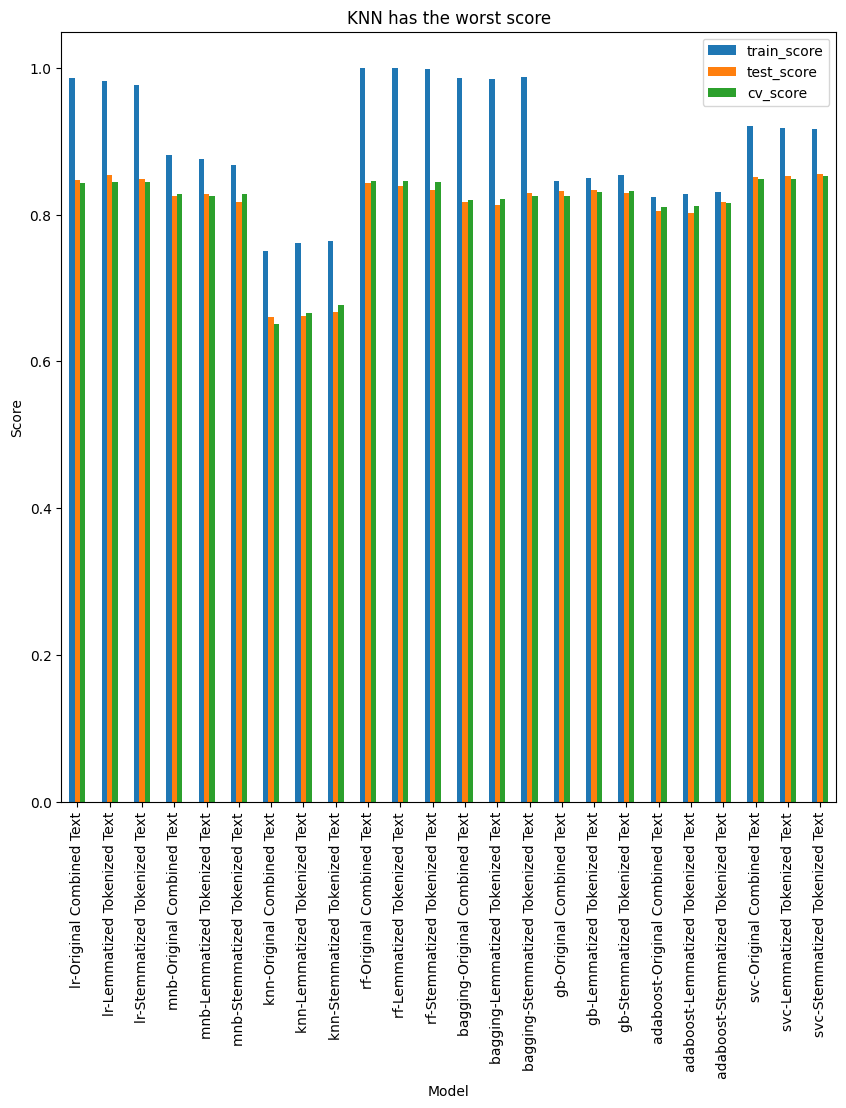

In [41]:
# Plot the results of train, test and cv score of all models
prelim_results.plot(x='model', y=['train_score', 'test_score', 'cv_score'], kind="bar", figsize=(10, 10))
plt.ylabel('Score')
plt.xlabel('Model')
plt.title('KNN has the worst score');

In [ ]:
# Display the models with top train score
prelim_results.sort_values(by='train_score', ascending = False).head()

,model,train_score,test_score
9,rf-Original Combined Text,0.999125,0.8420
10,rf-Lemmatized Tokenized Text,0.999000,0.8380
11,rf-Stemmatized Tokenized Text,0.998875,0.8350
0,lr-Original Combined Text,0.986375,0.8470
14,bagging-Stemmatized Tokenized Text,0.985250,0.8335


Random Forest Classifier has the best train score, however, the test score is quite far apart which shows that random forest classifier is overfitting.

In [ ]:
# Display the models with top test score
prelim_results.sort_values(by='test_score', ascending = False).head()

,model,train_score,test_score
23,svc-Stemmatized Tokenized Text,0.916500,0.8555
1,lr-Lemmatized Tokenized Text,0.982500,0.8535
22,svc-Lemmatized Tokenized Text,0.918000,0.8525
21,svc-Original Combined Text,0.920000,0.8515
2,lr-Stemmatized Tokenized Text,0.977125,0.8485


SVC on Stemmatized tokenized text gives us the best test score. Besides that the train score of this model using default hyperparamet is not very far apart from test score. It might be able to do better, further research is required.

In [ ]:
# Calculate the difference between train and test score of each model
prelim_results['score_difference'] = prelim_results['train_score'] - prelim_results['test_score']

In [ ]:
# Display the models with least difference in train and test score
prelim_results.sort_values(by='score_difference').head()

,model,train_score,test_score,score_difference
20,adaboost-Stemmatized Tokenized Text,0.831375,0.8175,0.013875
16,gb-Lemmatized Tokenized Text,0.849625,0.8335,0.016125
15,gb-Original Combined Text,0.846125,0.8290,0.017125
18,adaboost-Original Combined Text,0.823250,0.8045,0.018750
17,gb-Stemmatized Tokenized Text,0.854375,0.8300,0.024375


Out of all the models, AdaBoost classifier has the smallest difference between train score and test score on the stemmatized tokenized text. It has the best bias-variance tradeoff out of all the models with default hyperparameter. However, it does not have very high test accuracy. CV score has to be taken into consideration to understand how well a model is when performing with different train and test data.

In [42]:
# Display model with top CV score
prelim_results.sort_values(by='cv_score', ascending = False).head()

,model,train_score,test_score,cv_scores,cv_score
23,svc-Stemmatized Tokenized Text,0.916500,0.8555,"[0.8473940757405324, 0.8533933258342707, 0.855...",0.852125
22,svc-Lemmatized Tokenized Text,0.918000,0.8525,"[0.8432695913010874, 0.8488938882639671, 0.854...",0.849001
21,svc-Original Combined Text,0.920000,0.8515,"[0.8432695913010874, 0.8440194975628047, 0.858...",0.848501
9,rf-Original Combined Text,0.999125,0.8425,"[0.8518935133108362, 0.8308961379827522, 0.856...",0.846376
10,rf-Lemmatized Tokenized Text,0.999000,0.8390,"[0.8481439820022497, 0.8350206224221972, 0.855...",0.846126


Besides test score, SVC has the highest cross validation score followed by Random Forest Classifier.

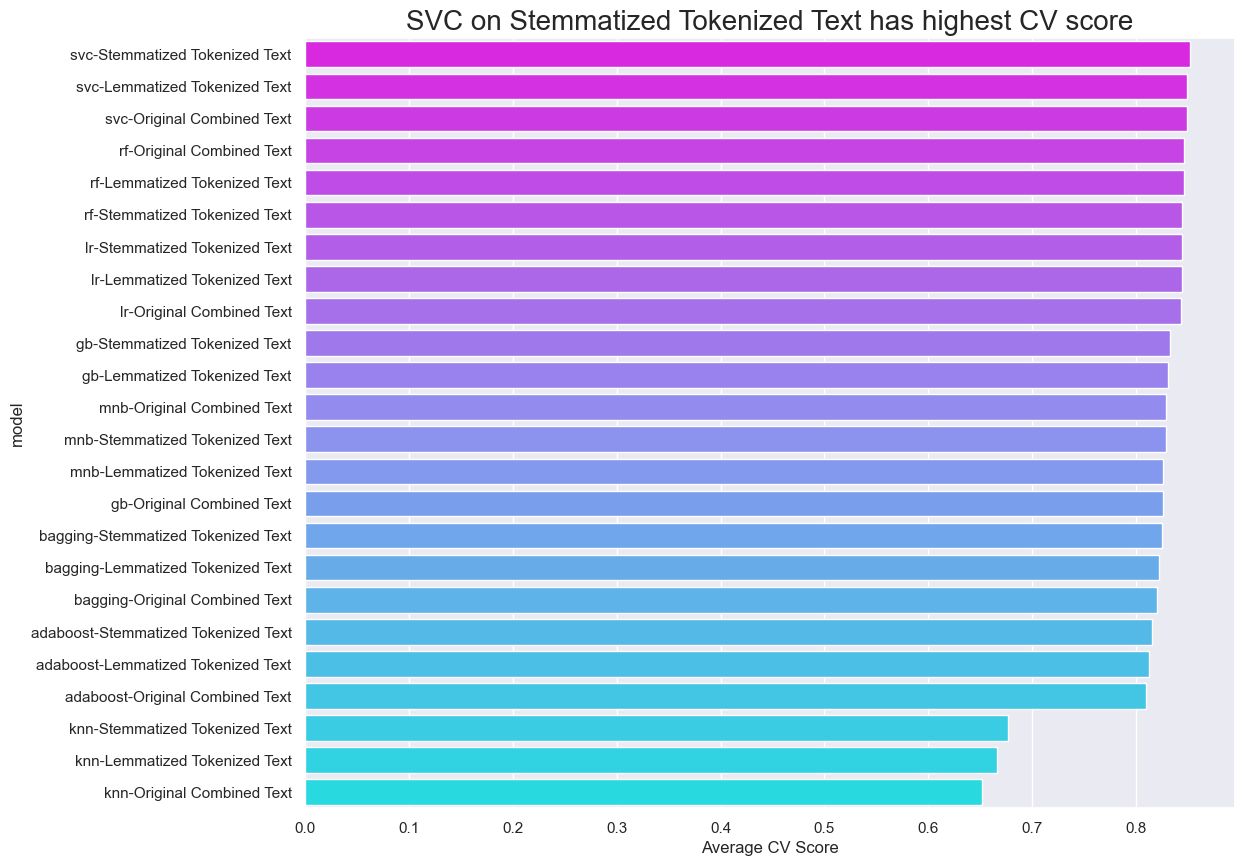

In [54]:
# Plot CV score of all models in descending order
sns.set(rc={'figure.figsize':(12,10)})
sns.barplot(x='cv_score',y='model',data=prelim_results,\
    order=prelim_results.dropna().sort_values('cv_score', ascending=False).model,palette='cool_r')
plt.title('SVC on Stemmatized Tokenized Text has highest CV score',fontsize=20)
plt.xlabel('Average CV Score');

From the information above, we will select two models based on the highest average cross validation score which are SVC and Random Forest Classifier.  

|Model for further research|Text Used|
|---|---|
|Random Forest|Original Combined Text|
|SVC|Stemmatized Tokenized Text|

In [55]:
# Export preliminary results into a csv file
prelim_results.to_csv('../Data/preliminary_results.csv')